In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
df = pd.read_csv('triton_rezultati.csv')
# remove all rows in model that contain 'rt-'
df = df[~df['model'].str.contains('rt-')]
df

,test,model,batch_size,floating_point,concurrency,kv_cache,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,...,Server Compute Input,Server Compute Infer,Server Compute Output,Client Recv,p50 latency,p90 latency,p95 latency,p99 latency,request/response,response wait
0,alpha,gemma3,1,fp16,1:24:2,0,1,0.643508,50,719,...,17,1550278,39,0,1542649,1545638,1546397,1561484,50,1551326
1,alpha,gemma3,2,fp16,1:24:2,0,19,1.185160,54,819,...,66,6588780,81,0,32932954,32973698,32975293,34715581,54,30954911
2,alpha,gemma3,2,fp16,1:24:2,0,11,1.203680,48,752,...,41,6208113,74,0,18114342,18157300,19758219,19796982,48,18116455
3,alpha,gemma3,2,fp16,1:24:2,0,5,1.203680,51,815,...,34,5601306,73,0,8238339,8254527,8257616,8259402,51,8238383
4,alpha,gemma3,2,fp16,1:24:2,0,9,1.203680,54,820,...,33,5777241,83,0,14816465,16490745,16580923,18095577,54,14707821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,eta,meta-llama,8,f32,1:128:16,4096,97,9.975200,63,819,...,15,6415189,41,0,77767894,78726780,78977638,79291565,63,76401304
340,eta,meta-llama,8,f32,1:128:16,4096,17,9.975210,57,852,...,15,6361591,40,0,12934665,17306819,17947289,18699054,57,13441151
341,eta,meta-llama,8,f32,1:128:16,4096,49,10.049300,68,825,...,15,6384674,40,0,38963063,40112804,40538449,41501947,68,38439086
342,eta,meta-llama,8,f32,1:128:16,4096,65,10.061600,60,838,...,15,6359496,41,0,51581422,52862652,53235062,53730334,60,50795105


In [12]:
### concatenate test, batch_size, floating_point, kv_cache in one column
df['test'] = (df['test'].astype(str) + '_b' + df['batch_size'].astype(str) + '_' + df['floating_point'].astype(str) +
              '_kv' + df['kv_cache'].astype(str))
df.head()

,test,model,batch_size,floating_point,concurrency,kv_cache,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,...,Server Compute Input,Server Compute Infer,Server Compute Output,Client Recv,p50 latency,p90 latency,p95 latency,p99 latency,request/response,response wait
0,alpha_b1_fp16_kv0,gemma3,1,fp16,1:24:2,0,1,0.643508,50,719,...,17,1550278,39,0,1542649,1545638,1546397,1561484,50,1551326
1,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,19,1.185160,54,819,...,66,6588780,81,0,32932954,32973698,32975293,34715581,54,30954911
2,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,11,1.203680,48,752,...,41,6208113,74,0,18114342,18157300,19758219,19796982,48,18116455
3,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,5,1.203680,51,815,...,34,5601306,73,0,8238339,8254527,8257616,8259402,51,8238383
4,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,9,1.203680,54,820,...,33,5777241,83,0,14816465,16490745,16580923,18095577,54,14707821


In [13]:
#Zadrži samo relevantne kolone\n",
df_filtered = df[
 ['test', 'model', 'batch_size', 'floating_point', 'kv_cache',
  'Concurrency', 'Inferences/Second',
'p50 latency', 'p90 latency', 'p95 latency', 'p99 latency', 'response wait']].copy()

# convert latency columns to seconds from microseconds
df_filtered['p50 latency'] = round(df_filtered['p50 latency'] / 1000000, 3)
df_filtered['p90 latency'] = round(df_filtered['p90 latency'] / 1000000, 3)
df_filtered['p95 latency'] = round(df_filtered['p95 latency'] / 1000000, 3)
df_filtered['p99 latency'] = round(df_filtered['p99 latency'] / 1000000, 3)

In [14]:
# Add a combined metric
df_filtered['throughput_latency_ratio'] = df_filtered['Inferences/Second'] / df_filtered['p99 latency']
# For each test and model, get the row with the highest ratio
best_rows = df_filtered.loc[df_filtered.groupby(['test', 'model'])['throughput_latency_ratio'].idxmax()]

In [15]:
# order by highest throughput_latency_ratio
best_rows = best_rows.sort_values(by='throughput_latency_ratio', ascending=False)
# Display the best rows
best_rows.reset_index(drop=True, inplace=True)
best_rows.head(10)

,test,model,batch_size,floating_point,kv_cache,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,beta_b8_bf16_kv0,mistral,8,bf16,0,5,13.64180,2.917,3.045,3.082,3.165,2926345,4.310205
1,eta_b8_f16_kv4096,gemma3,8,f16,4096,1,4.58020,1.741,1.746,1.747,1.749,1749885,2.618754
2,gama_b8_bf16_kv128,gemma3,8,bf16,128,1,4.55551,1.747,1.750,1.751,1.753,1756092,2.598694
3,eta_b8_bf16_kv4096,gemma3,8,bf16,4096,1,4.50612,1.768,1.771,1.773,1.776,1774836,2.537230
4,beta_b8_bf16_kv0,gemma3,8,bf16,0,1,4.49378,1.765,1.774,1.774,1.776,1775727,2.530282
5,delta_b8_bf16_kv256,gemma3,8,bf16,256,1,4.77773,1.671,1.674,1.675,2.197,1676417,2.174661
6,epsilon_b8_bf16_kv4096,gemma3,8,bf16,4096,1,4.71600,1.691,1.696,1.697,2.230,1695595,2.114798
7,gama_b8_bf16_kv128,mistral,8,bf16,128,9,14.39490,4.551,6.609,6.913,7.215,4989904,1.995135
8,eta_b8_f16_kv4096,mistral,8,f16,4096,9,14.61710,4.439,7.348,7.552,7.768,4918528,1.881707
9,beta_b8_bf16_kv0,meta-llama,8,bf16,0,5,9.02461,4.403,4.839,4.929,5.139,4424416,1.756102


In [16]:
# remove Concurrency column
best_rows.drop(columns=['Concurrency'], inplace=True)
# Display the best rows
best_rows.reset_index(drop=True, inplace=True)
best_rows.head(20)

,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,beta_b8_bf16_kv0,mistral,8,bf16,0,13.64180,2.917,3.045,3.082,3.165,2926345,4.310205
1,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.58020,1.741,1.746,1.747,1.749,1749885,2.618754
2,gama_b8_bf16_kv128,gemma3,8,bf16,128,4.55551,1.747,1.750,1.751,1.753,1756092,2.598694
3,eta_b8_bf16_kv4096,gemma3,8,bf16,4096,4.50612,1.768,1.771,1.773,1.776,1774836,2.537230
4,beta_b8_bf16_kv0,gemma3,8,bf16,0,4.49378,1.765,1.774,1.774,1.776,1775727,2.530282
5,delta_b8_bf16_kv256,gemma3,8,bf16,256,4.77773,1.671,1.674,1.675,2.197,1676417,2.174661
6,epsilon_b8_bf16_kv4096,gemma3,8,bf16,4096,4.71600,1.691,1.696,1.697,2.230,1695595,2.114798
7,gama_b8_bf16_kv128,mistral,8,bf16,128,14.39490,4.551,6.609,6.913,7.215,4989904,1.995135
8,eta_b8_f16_kv4096,mistral,8,f16,4096,14.61710,4.439,7.348,7.552,7.768,4918528,1.881707
9,beta_b8_bf16_kv0,meta-llama,8,bf16,0,9.02461,4.403,4.839,4.929,5.139,4424416,1.756102


In [17]:
# from the best rows get the best for each model
best_per_model = best_rows.loc[best_rows.groupby('model')['throughput_latency_ratio'].idxmax()]
best_per_model = best_per_model.sort_values(by='throughput_latency_ratio', ascending=False)
# Reset index for better readability
best_per_model.reset_index(drop=True, inplace=True)
# Display the best rows
best_per_model.head(20)

# remove batch size. p50 latency, p90 latency, response wait
best_per_model = best_per_model.drop(columns=['p50 latency', 'p90 latency', 'p95 latency', 'response wait'])
# Display the best rows
best_per_model.reset_index(drop=True, inplace=True)
best_per_model

,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p99 latency,throughput_latency_ratio
0,beta_b8_bf16_kv0,mistral,8,bf16,0,13.64180,3.165,4.310205
1,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.58020,1.749,2.618754
2,beta_b8_bf16_kv0,meta-llama,8,bf16,0,9.02461,5.139,1.756102


### Best configurations for mistral


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,beta_b8_bf16_kv0,mistral,8,bf16,0,13.6418,2.917,3.045,3.082,3.165,2926345,4.310205




### Best configurations for gemma3


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
1,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.5802,1.741,1.746,1.747,1.749,1749885,2.618754




### Best configurations for meta-llama


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
9,beta_b8_bf16_kv0,meta-llama,8,bf16,0,9.02461,4.403,4.839,4.929,5.139,4424416,1.756102


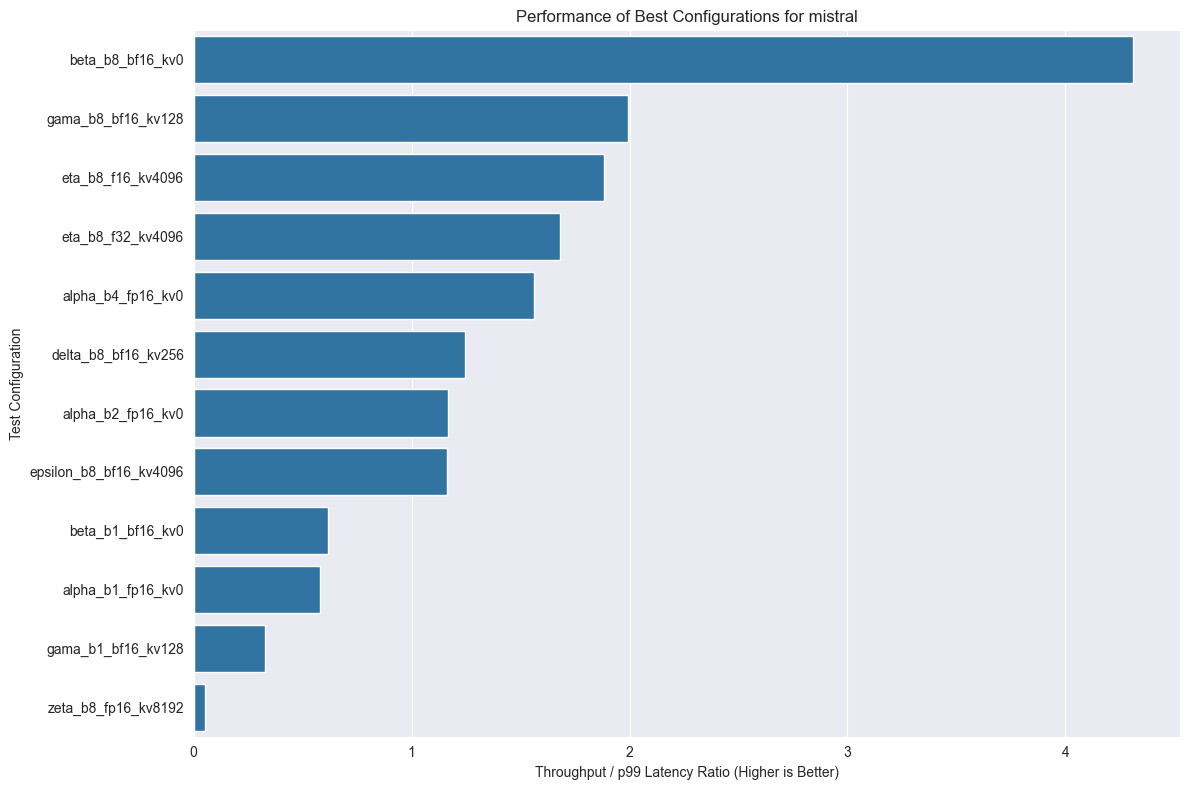

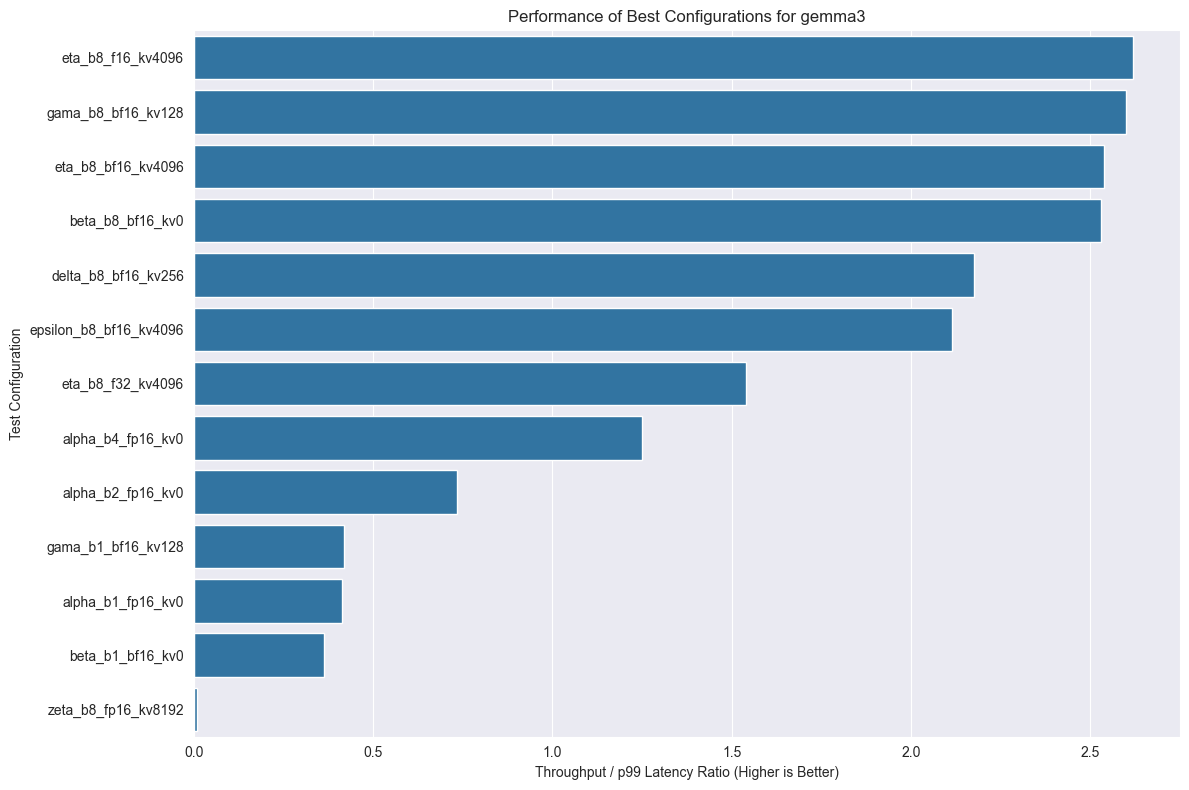

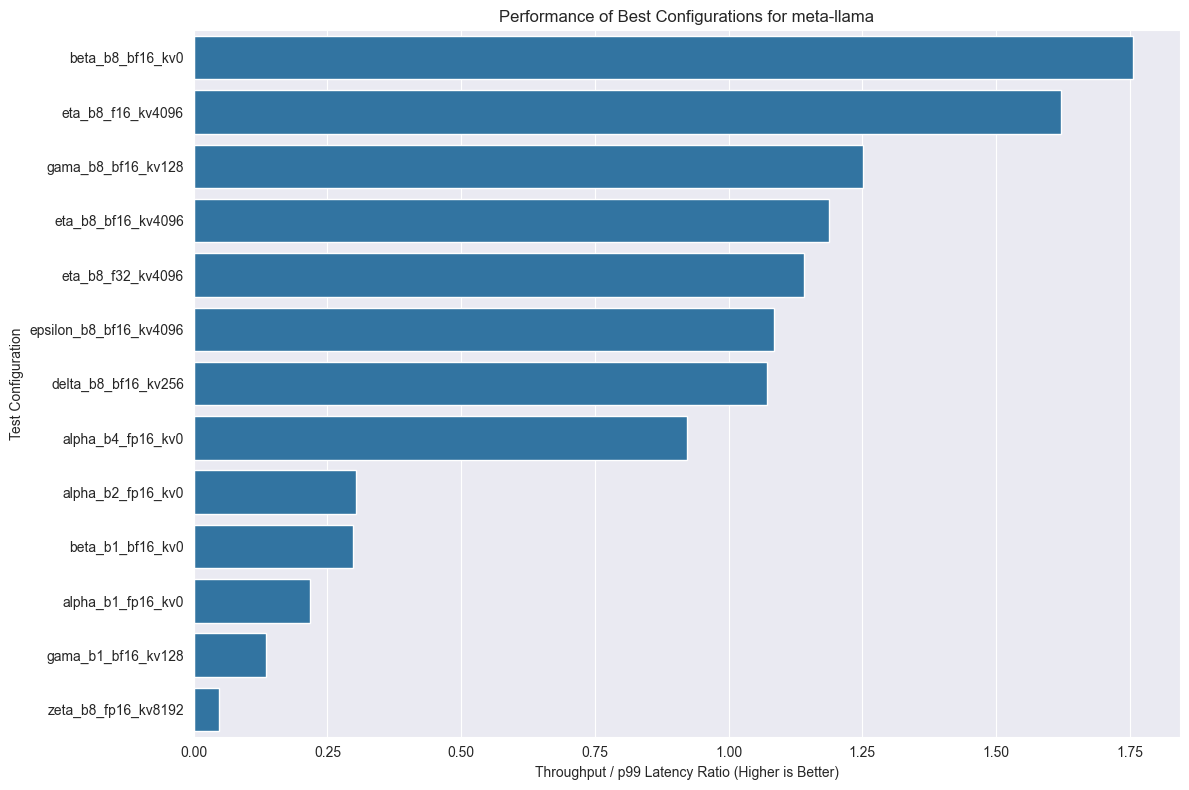

In [18]:
# Create a dictionary to hold the dataframes for each model
model_dfs = {}
unique_models = best_rows['model'].unique()

# Split the dataframe by model
for model in unique_models:
    # Sort by the ratio to have the best results on top for each model
    model_df = best_rows[best_rows['model'] == model].sort_values(by='throughput_latency_ratio', ascending=False)
    model_dfs[model] = model_df

# Display the table for each model
for model_name, df_model in model_dfs.items():
    print(f"### Best configurations for {model_name}")
    display(df_model.head(1))
    print("\n")

# Create and display visuals for each model
for model_name, df_model in model_dfs.items():
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_model, x='throughput_latency_ratio', y='test', orient='h')
    plt.title(f'Performance of Best Configurations for {model_name}')
    plt.xlabel('Throughput / p99 Latency Ratio (Higher is Better)')
    plt.ylabel('Test Configuration')
    plt.tight_layout()
    plt.show()

In [23]:
import pandas as pd

# Load the user perspective metrics
df1 = pd.read_csv('prompts_single/1_prompt_test_results.csv')
df2 = pd.read_csv('prompts_single/2_chat_test_results.csv')
df3 = pd.read_csv('prompts_single/3_summarize_test_results.csv')
df4 = pd.read_csv('prompts_single/4_batch_test_results.csv')

df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Calculate average user metrics per model
# We select numeric columns that represent user-perceived performance
user_metrics_agg = df.groupby('model')[['ttft', 'tpot', 'latency']].mean().reset_index()

# Rename columns to be clear after merging
user_metrics_agg.rename(columns={
    'ttft': 'avg_user_ttft',
    'tpot': 'avg_user_tpot',
    'latency': 'avg_user_latency'
}, inplace=True)

# Merge the aggregated user metrics with the best_rows dataframe
# This merge is done on the 'model' column
merged_df = pd.merge(best_rows, user_metrics_agg, on='model', how='left')

# Display the first few rows of the merged dataframe with first three best models results
merged_df_filtered = merged_df.head(3)
merged_df_filtered

,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio,avg_user_ttft,avg_user_tpot,avg_user_latency
0,beta_b8_bf16_kv0,mistral,8,bf16,0,13.64180,2.917,3.045,3.082,3.165,2926345,4.310205,2.692862,0.021169,2.701446
1,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.58020,1.741,1.746,1.747,1.749,1749885,2.618754,10.902989,0.085332,10.911251
2,gama_b8_bf16_kv128,gemma3,8,bf16,128,4.55551,1.747,1.750,1.751,1.753,1756092,2.598694,10.902989,0.085332,10.911251


In [24]:
#
top_row_df = merged_df_filtered.head(1)

# Transpose the dataframe to view it vertically
# This turns columns into rows for easier reading of a single record
top_row_df.T

,0
test,beta_b8_bf16_kv0
model,mistral
batch_size,8
floating_point,bf16
kv_cache,0
Inferences/Second,13.6418
p50 latency,2.917
p90 latency,3.045
p95 latency,3.082
p99 latency,3.165


In [25]:
# remove all rt- models
df = df[df['model'].str.contains('rt-') == False]


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pretpostavlja se da df_server ima stupce: model, batch_size, p50_latency, p90_latency, p95_latency, p99_latency

latency_cols = ['p50 latency', 'p90 latency', 'p95 latency', 'p99 latency']
df_lat = df.melt(id_vars=['model', 'batch_size'], value_vars=latency_cols,
                       var_name='latency_type', value_name='latency')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_lat, x='latency_type', y='latency', hue='model')
plt.title('Distribucija latencija po modelu')
plt.ylabel('Latencija (ms)')
plt.xlabel('Percentil latencije')
plt.legend(title='Model')
plt.show()

ValueError: value_name (latency) cannot match an element in the DataFrame columns.

In [27]:
plt.figure(figsize=(8, 5))
for model in df['model'].unique():
    subset = df[df['model'] == model]
    plt.plot(subset['concurrency'], subset['Inferences/Second'], marker='o', label=model)
plt.xlabel('Concurrency')
plt.ylabel('Inferences/Second')
plt.title('Propusnost modela ovisno o concurrency')
plt.legend()
plt.show()

KeyError: 'concurrency'

<Figure size 800x500 with 0 Axes>

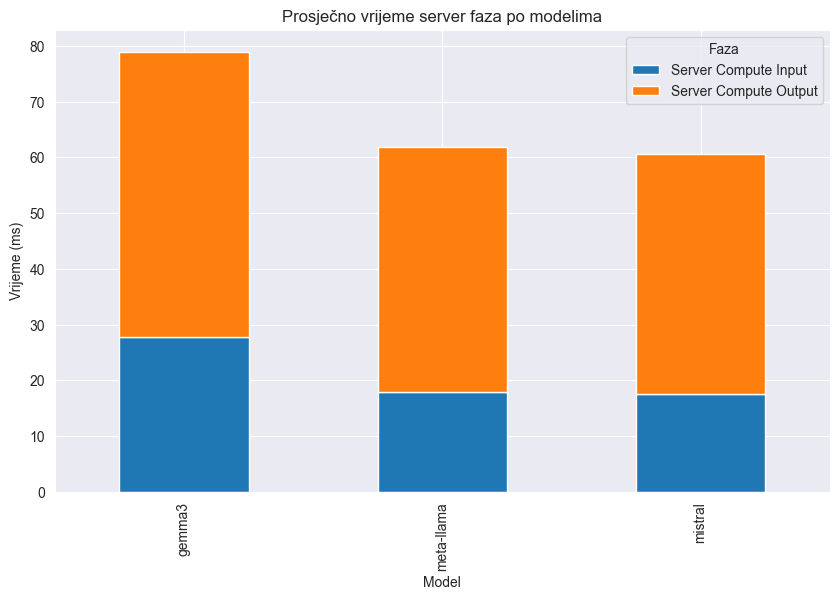

In [24]:
stages = ['Server Compute Input', 'Server Compute Output']
grouped = df.groupby('model')[stages].mean()

grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Model')
plt.ylabel('Vrijeme (ms)')
plt.title('Prosječno vrijeme server faza po modelima')
plt.legend(title='Faza')
plt.show()

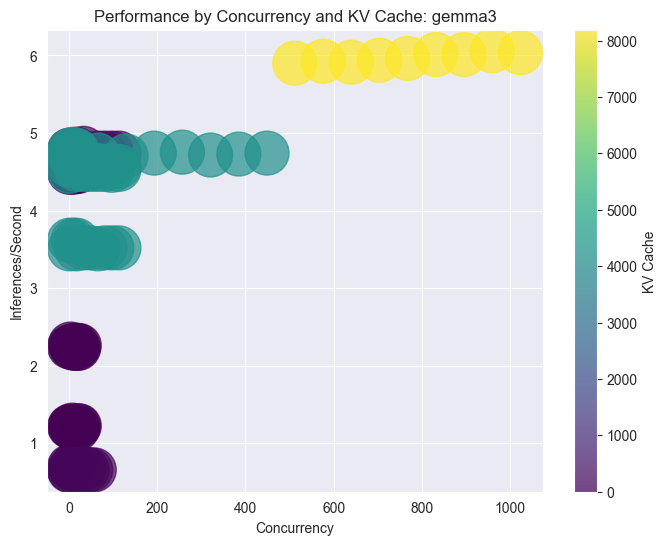

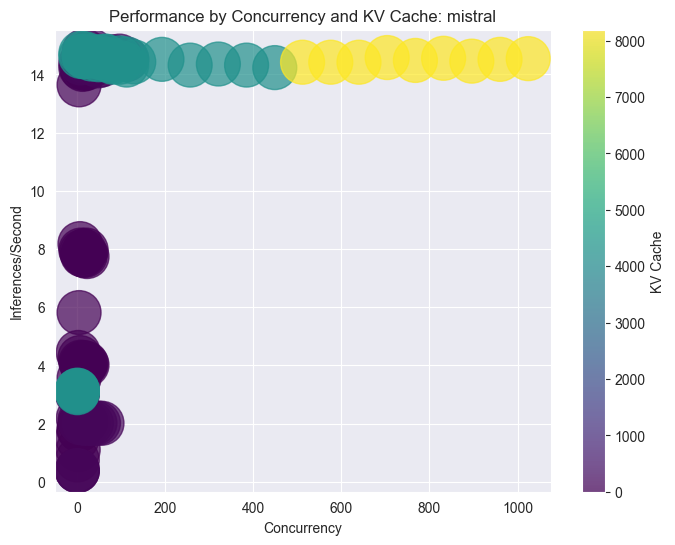

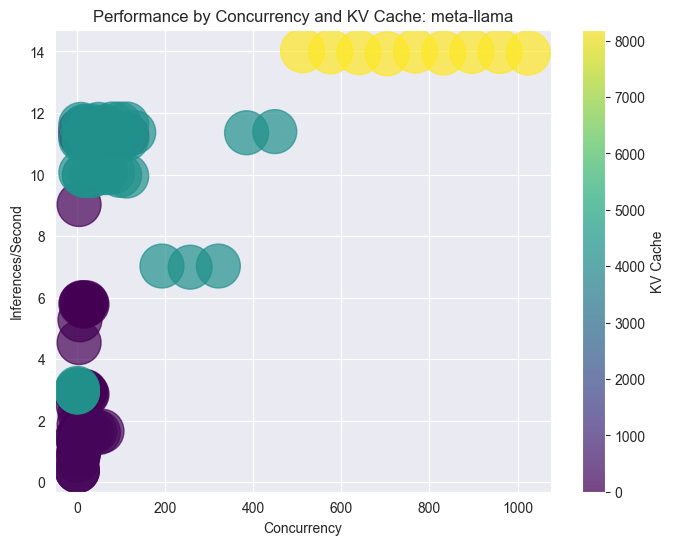

In [21]:
import matplotlib.pyplot as plt
import numpy as np

for model in df['model'].unique():
    subset = df[df['model'] == model]
    marker_sizes = np.clip(subset['p99 latency'] * 500, 10, 1000)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        subset['Concurrency'],
        subset['Inferences/Second'],
        c=subset['kv_cache'],
        s=marker_sizes,
        cmap='viridis',
        alpha=0.7
    )
    cbar = plt.colorbar(scatter, label='KV Cache')
    plt.xlabel('Concurrency')
    plt.ylabel('Inferences/Second')
    plt.title(f'Performance by Concurrency and KV Cache: {model}')
    plt.show()